# Feature engineering

## Setup

In [17]:
%pip install -r ../requirements.txt

In [18]:
import sys
sys.path.append('../')

In [19]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm # DO NOT REMOVE

from typing import List

%matplotlib inline

## Run setup


In [20]:
CSV_PATH = "../data/gym_members_exercise_tracking.csv"
df = pd.read_csv(CSV_PATH)

In [21]:
from libs.setup import Run

run = Run(Path.joinpath(Path.cwd().parent, "runs")).initialize()

run.add_raw(df, filename="gym_members_exercise_tracking")

17:46:55 - INFO - Data saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\data\raw\gym_members_exercise_tracking.csv
17:46:55 - INFO - Data saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\data\raw\gym_members_exercise_tracking.csv


WindowsPath('c:/Users/drwni/Desktop/MEINF/AI/WP_01/runs/2024-12-15_17-46-55/data/raw/gym_members_exercise_tracking.csv')

## Feature creation

In [22]:
# Show missing values
_null = df.isnull().sum()

print(_null[_null > 0] if any(_null) else "No missing values")

No missing values


There are no missing values in the dataset, so we won't have to create any missing imputation.

## Feature encoding

In [35]:
from sklearn.preprocessing import OneHotEncoder

_encoder = OneHotEncoder()
_encoded_categorical = pd.DataFrame(
    _encoder.fit_transform(df.select_dtypes(include=['object'])).toarray(), 
    columns=_encoder.get_feature_names_out(df.select_dtypes(include=['object']).columns),
)

encoded_df = df.drop(columns=df.select_dtypes(include=['object']).columns)
encoded_df = pd.concat([encoded_df, _encoded_categorical], axis=1)
encoded_df.head()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Gender_Female,Gender_Male,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
0,56,88.3,1.71,180,157,60,1.69,1313.0,12.6,3.5,4,3,30.20,0.0,1.0,0.0,0.0,0.0,1.0
1,46,74.9,1.53,179,151,66,1.30,883.0,33.9,2.1,4,2,32.00,1.0,0.0,0.0,1.0,0.0,0.0
2,32,68.1,1.66,167,122,54,1.11,677.0,33.4,2.3,4,2,24.71,1.0,0.0,1.0,0.0,0.0,0.0
3,25,53.2,1.70,190,164,56,0.59,532.0,28.8,2.1,3,1,18.41,0.0,1.0,0.0,0.0,1.0,0.0
4,38,46.1,1.79,188,158,68,0.64,556.0,29.2,2.8,3,1,14.39,0.0,1.0,0.0,0.0,1.0,0.0


## Feature selection

 We will check each feature's importance using an estimator with ```feature_importance```, for example ```ExtraTreesRegressor``` and ```Lasso```

In [36]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

TARGET = "Calories_Burned"

X = encoded_df.drop(columns=[TARGET])
y = encoded_df[TARGET]

In [37]:
# Using the parameters from the scikit-learn documentation
models = {
    "ExtraTreesRegressor": ExtraTreesRegressor(),
    "Lasso": Lasso(alpha=0.1),
}

X_data = {}

for name, model in models.items():
    selector = SelectFromModel(model).fit(X, y)
    _support = selector.get_support()
    _features = X.columns[_support]
    X_data[name] = X[_features]
    print(f"Selected features from {name}: {_features}")

Selected features from ExtraTreesRegressor: Index(['Avg_BPM', 'Session_Duration (hours)', 'Experience_Level'], dtype='object')
Selected features from Lasso: Index(['Age', 'Weight (kg)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
       'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI',
       'Gender_Female', 'Workout_Type_Cardio', 'Workout_Type_Yoga'],
      dtype='object')


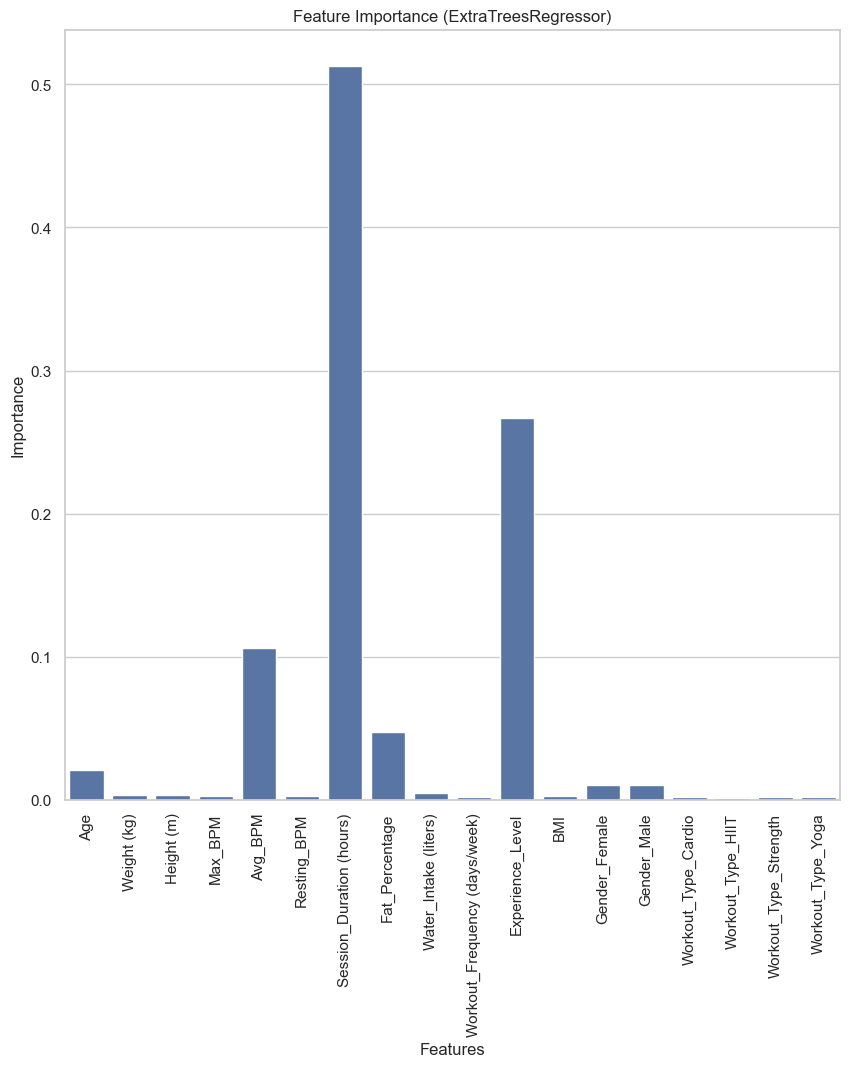

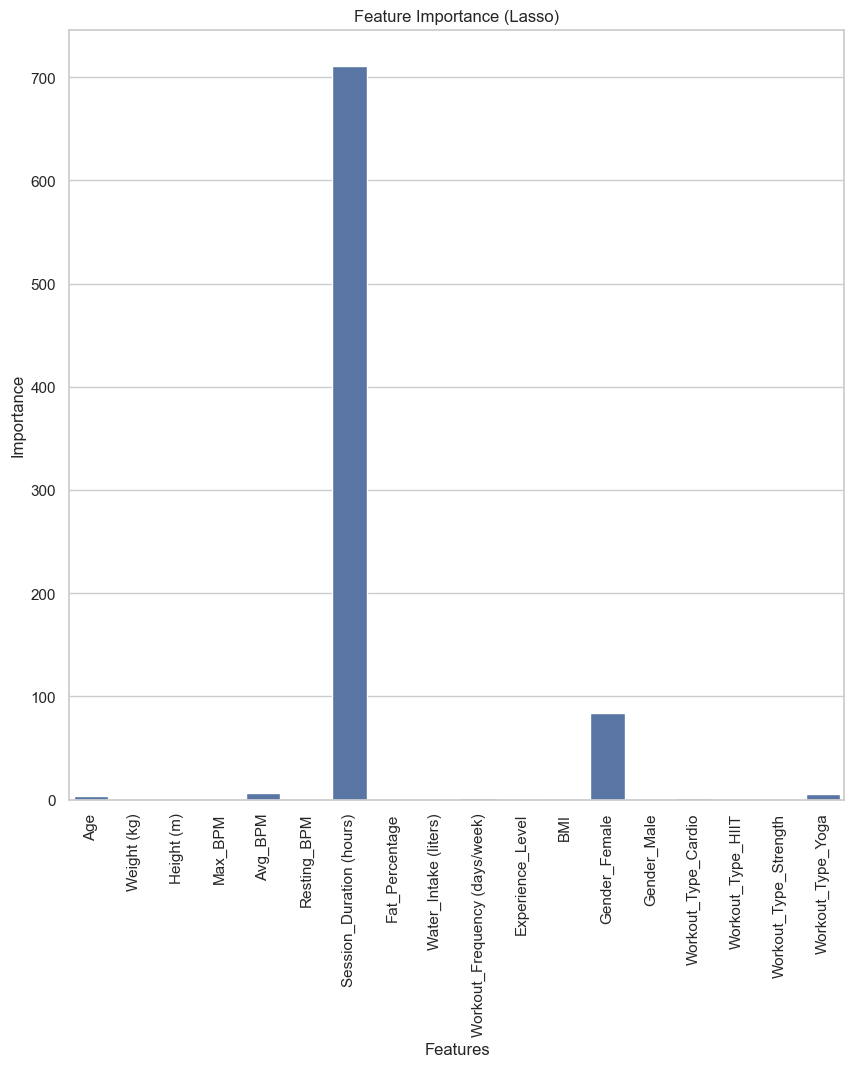

In [39]:
# Feature Importance plots
for name, model in models.items():
    model.fit(X, y)
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 10))
    sns.barplot(y=model.feature_importances_ if name == "ExtraTreesRegressor" else np.abs(model.coef_), x=X.columns)
    plt.title(f"Feature Importance ({name})")
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.xticks(rotation=90)
    plt.show()

In [40]:
X_data["ExtraTreesRegressor"].head()

,Avg_BPM,Session_Duration (hours),Experience_Level
0,157,1.69,3
1,151,1.30,2
2,122,1.11,2
3,164,0.59,1
4,158,0.64,1


In [41]:
X_data["Lasso"].head()

,Age,Weight (kg),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Gender_Female,Workout_Type_Cardio,Workout_Type_Yoga
0,56,88.3,180,157,60,1.69,12.6,3.5,4,3,30.20,0.0,0.0,1.0
1,46,74.9,179,151,66,1.30,33.9,2.1,4,2,32.00,1.0,0.0,0.0
2,32,68.1,167,122,54,1.11,33.4,2.3,4,2,24.71,1.0,1.0,0.0
3,25,53.2,190,164,56,0.59,28.8,2.1,3,1,18.41,0.0,0.0,0.0
4,38,46.1,188,158,68,0.64,29.2,2.8,3,1,14.39,0.0,0.0,0.0


In [42]:
# Save processed dataframes
for name, data in X_data.items():
    _df = pd.concat([data, y], axis=1)
    run.add_processed(_df, filename=f"{name}_selected_features")

17:48:51 - INFO - Data saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\data\processed\ExtraTreesRegressor_selected_features.csv
17:48:51 - INFO - Data saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\data\processed\ExtraTreesRegressor_selected_features.csv
17:48:51 - INFO - Data saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\data\processed\Lasso_selected_features.csv
17:48:51 - INFO - Data saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\data\processed\Lasso_selected_features.csv


### Compare the performance of the models with the selected features

In [51]:
from sklearn.model_selection import train_test_split

TARGET = "Calories_Burned"

class TrainingData:
    
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    
    def __init__(self, X: pd.DataFrame, y: pd.Series, name: str):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TrainingData.TEST_SIZE, random_state=TrainingData.RANDOM_STATE)
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.name = name
        
        run.logger.info(f"{X_train.shape}, {y_train.shape}")
        run.logger.info(f"{X_test.shape}, {y_test.shape}")
        

training: List[TrainingData] = [TrainingData(_X, y, name) for name, _X in X_data.items()]
len(training)

17:51:29 - INFO - (778, 3), (778,)
17:51:29 - INFO - (778, 3), (778,)
17:51:29 - INFO - (195, 3), (195,)
17:51:29 - INFO - (195, 3), (195,)
17:51:29 - INFO - (778, 14), (778,)
17:51:29 - INFO - (778, 14), (778,)
17:51:29 - INFO - (195, 14), (195,)
17:51:29 - INFO - (195, 14), (195,)


2

In [52]:
import os

# For saving the models
from joblib import dump
from datetime import datetime
import humanize

# The metrics we will use to evaluate and compare the models
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline

def evaluate(self, models) -> dict[str, dict[str, float]]:
    metrics = {
        "R2 Score": r2_score,
        "RMSE": root_mean_squared_error,
    }

    scores = {}

    for name, metric in metrics.items():
        run.logger.info(f"Calculating {name} for each model")
        scores[name] = {}
        for model_name, model in models.items():
            y_pred = model.predict(self.X_test)
            score = metric(self.y_test, y_pred)
            scores[name][model_name] = score
            run.logger.info(f"{model_name} {name}: {score}")
            
    return scores
        

def model_training(self, pipelines: List[Pipeline]) -> dict[str, Pipeline]:
    """Trains the models in the pipelines list and returns a dictionary of the trained models.

    Args:
        pipelines (List[Pipeline]): pipelines to train with.

    Returns:
        dict[str, Pipeline]: dictionary of trained models.
    """

    models = {}
    train_results = pd.DataFrame(columns=["Model Name", "Training Time", "File Size"])

    # Train models
    for num, pipeline in enumerate(pipelines, start=1):
        model_name = pipeline.named_steps["model"].__class__.__name__.lower()

        t_start = datetime.now()
        
        models[model_name] = pipeline.fit(self.X_train, self.y_train)

        duration = str((datetime.now() - t_start).seconds)

        # model_name = model_names[num - 1].__name__.lower()
        model_path = run.add_model(models[model_name], model_name)

        dump(pipeline, model_path, compress=True)

        # Track file size
        bytes_size = os.path.getsize(model_path)
        size = humanize.naturalsize(bytes_size)

        train_results.loc[model_name] = [model_name, duration, size]
        run.logger.info(f"(%02i/%02i) Finished training {model_name} in {duration}", num, len(pipelines))

    # Save train results to file
    train_results.to_csv(run.paths.base / "train_results.csv")
    
    return models
    
    
TrainingData.evaluate = evaluate
TrainingData.model_training = model_training 

In [53]:
# Basic preprocessing for testing
from sklearn.preprocessing import StandardScaler

# The models we will train with
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


models = [
    LinearRegression, 
    Lasso, 
    Ridge, 
    DecisionTreeRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    SVR, 
    MLPRegressor,
]

pipelines = []

for model in models:
    pipelines.append(Pipeline([
        ('scaler', StandardScaler()), 
        ('model', model())
    ]))

In [54]:
for data in training:
    models = data.model_training(pipelines)
    scores = data.evaluate(models)
    
    data.scores_df = pd.DataFrame(scores)
    
    run.logger.info("Models trained successfully")
    run.logger.info(f"{models.keys()}")

17:51:31 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\models\linearregression
17:51:31 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\models\linearregression
17:51:31 - INFO - (01/08) Finished training linearregression in 0
17:51:31 - INFO - (01/08) Finished training linearregression in 0
17:51:31 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\models\lasso
17:51:31 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\models\lasso
17:51:31 - INFO - (02/08) Finished training lasso in 0
17:51:31 - INFO - (02/08) Finished training lasso in 0
17:51:31 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\models\ridge
17:51:31 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\models\ridge
17:51:31 - INFO - (03/08) Finished training ridge in 0
17:51:31 - INFO - (03/08) F

c:\Users\drwni\Desktop\MEINF\AI\WP_01\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


17:51:32 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\models\decisiontreeregressor
17:51:32 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\models\decisiontreeregressor
17:51:32 - INFO - (04/08) Finished training decisiontreeregressor in 0
17:51:32 - INFO - (04/08) Finished training decisiontreeregressor in 0
17:51:33 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\models\randomforestregressor
17:51:33 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\models\randomforestregressor
17:51:33 - INFO - (05/08) Finished training randomforestregressor in 0
17:51:33 - INFO - (05/08) Finished training randomforestregressor in 0
17:51:33 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_17-46-55\models\gradientboostingregressor
17:51:33 - INFO - Model saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_

c:\Users\drwni\Desktop\MEINF\AI\WP_01\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scores(scores_df: pd.DataFrame, title: str):
    """Plots the RMSE and R2 Score for each model.

    Args:
        scores_df (pd.DataFrame): DataFrame containing the scores for each model.
        title (str): Title of the plot.
    """
    fig = plt.figure(figsize=(12, 6))

    # Show RMSE and R2 Score as barplots
    fig.suptitle(f"Model Performance for {title}")
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.add_subplot(1, 2, 1)
    sns.barplot(x=scores_df.index, y=scores_df["RMSE"])
    plt.title("RMSE")
    plt.xticks(rotation=90)
    plt.ylabel("RMSE")
    plt.xlabel("Model")

    fig.add_subplot(1, 2, 2)
    sns.barplot(x=scores_df.index, y=scores_df["R2 Score"])
    plt.title("R2 Score")
    plt.xticks(rotation=90)
    plt.ylabel("R2 Score")
    plt.xlabel("Model")

    plt.show()
    

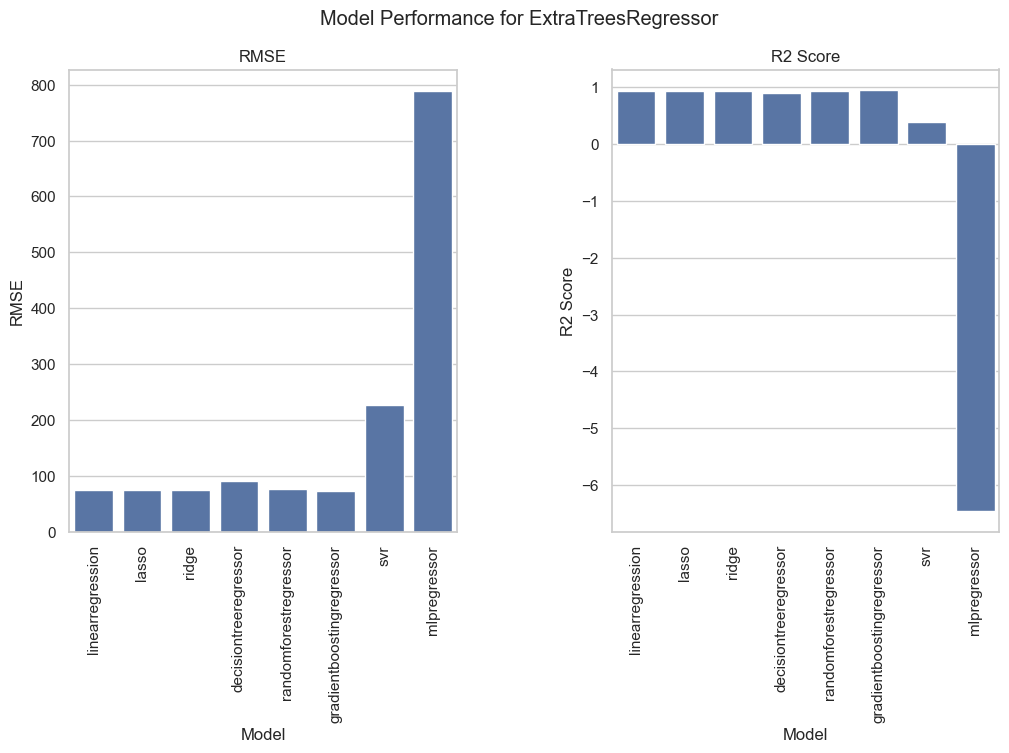

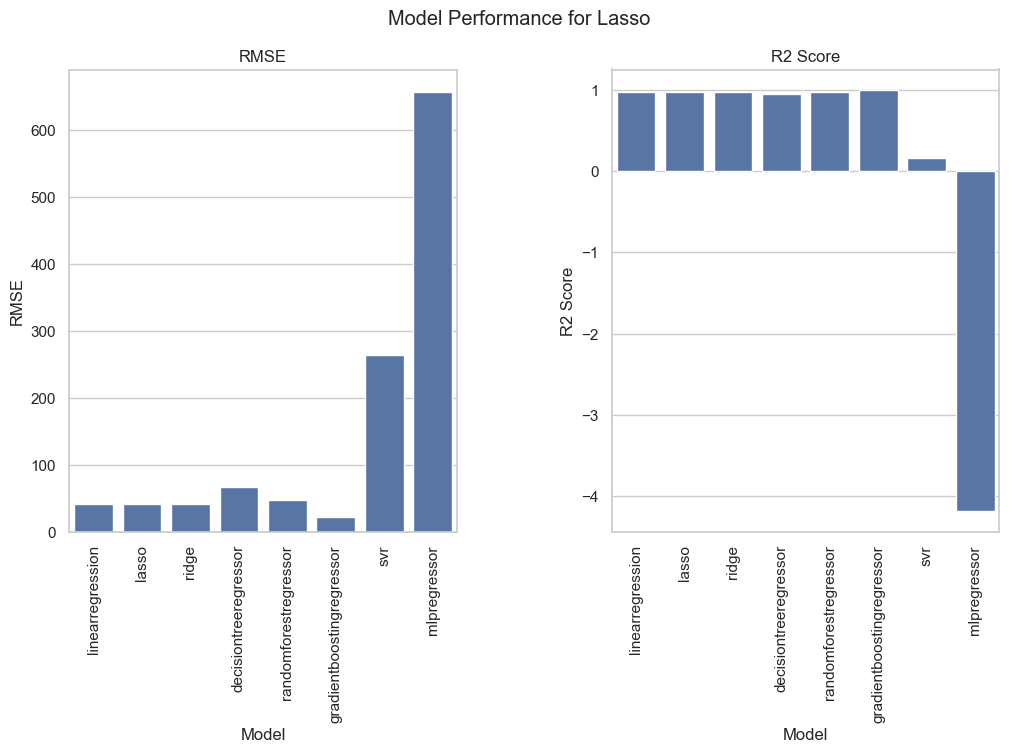

In [58]:
for data in training:
    plot_scores(data.scores_df, data.name)